# CW1 - CO202 Algorithms 2

## Introduction

The Discrete Fourier Transform (DFT) maps tuples $\mathbf{x}=(x_0,x_1,\dots,x_{N-1})$ of complex numbers to tuples $\mathbf{y}=(y_0,y_1,\dots,y_{N-1})$ of complex numbers satisfying
$$\space y_k:=\sum_{n=0}^{N-1}x_n e^{-\frac{2\pi i}{N}k n}=\sum_{n=0}^{N-1}x_n (\cos(2\pi k n/N)+i\sin(2\pi k n/N))$$
for $k=0,1,\dots,N-1$. In the expression above, $i$ denotes the imaginary unit.

We will denote the DFT of $\mathbf{x}$ by $\mathcal{F}(\mathbf{x})$. Then, $\mathcal{F}:\mathbb{C}^N\to\mathbb{C}^N$ is a linear, invertible transformation, where $\mathbb{C}$ denotes the set of complex numbers. 

We can recover $\mathbf{x}$ from $\mathbf{y}=\mathcal{F}(\mathbf{x})$ by computing
$$x_k=\frac{1}{N}\sum_{n=0}^{N-1}y_n e^{\frac{2\pi i}{N}k n}$$
for $k=0,1,\dots,N-1$. This formula leads to a simple way of computing $\mathbf{x}$ from $\mathbf{y}=\mathcal{F}(\mathbf{x})$ that only requires an algorithm for the forward DFT $\mathcal{F}$. More precisely, we have

$$x_k = \frac{\textrm{swap}\left(\mathcal{F}(\textrm{swap}(\mathbf{y}))_k\right)}{N}$$

for $k=0,1,\dots,N-1$, where $\textrm{swap}(a+bi)=b+ai$.

The DFT has many practical applications in computer science and electrical engineering. It is widely used in signal and image processing, and it even makes a crucial appearance in the fastest known algorithm for multiplying large integers. Because of this, it is of the utmost interest to find efficient algorithms for computing it.

Currently, the most efficient algorithm for computing the DFT is called the Fast Fourier Transform (FFT). It has runtime $O(N\log N)$ (if one assumes arithmetic operations take time $O(1)$), and is an important example of the divide-and-conquer approach to algorithm design. As a consequence, by the discussion above, there is also an algorithm computing the inverse DFT with runtime $O(N\log N)$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Exercise 1 (warmup)

Assuming arithmetic operations take time $O(1)$, write a Python program below for computing $\mathcal{F}(\mathbf{x})$ on input $\mathbf{x}\in\mathbb{C}^N$ in time $O(N^2)$. Briefly argue that the runtime of the proposed algorithm is indeed $O(N^2)$.

In [2]:
def naiveDFT(x):
    N = len(x)
    # commented out the assertion for timing function
    # assert N == 0 or np.log2(N) % 2 == 0
    k_nth_term = lambda k, n : x[n] * np.complex(np.cos(2 * np.pi * k * n / N),
                                                 np.sin(2 * np.pi * k * n / N))
    return np.array([sum(k_nth_term(k, n) for n in range(N)) for k in range(N)])

## Runtime of ```naiveDFT```

So in order to determine $\mathbf{y}[k]$, where $k\in{0,1,\dots,N-1}$, we apply the **```k_nth_term```** function (line 5) to each element in **x** and calculate the sum of each result. **```k_nth_term```**$=\mathcal{O}(c + d)$, where $\mathcal{O}(c)$ is the time complexity of accessesing the **n**th index in **x** and $\mathcal{O}(d)$ is the time complexity of the constant-time operation for calculating the general form of Eular's identity. 

Since $\mathbf{y, x}\in\mathbb{C}^N\land\mathbf{y}=\mathcal{F}(\mathbf{x})\land\mathcal{len}(\mathbf{y})=\mathcal{len}(\mathbf{x})$, in order to access each position in **y**, we will need to perform **N** (line 2) accesses. Each element in **y** is a function of every element in **x**:<br><br>

<center>
**```y[k] = sum(k_nth_term(k, n) for n in range(N))```**
$$
\begin{align}
&= \sum_{n=0}^{N-1}\mathcal{O}(c + d) \\
&= \sum_{n=0}^{N-1} C & (*)\\
\end{align}
$$
</center>


We perform the above calculation for all values of $k\in{0,1,\dots,N-1}$, we get the following nested sum which is implemented by a nested for loop (line 7): 

$$
\begin{align}
y = \mathcal{F}(x) &= \sum_{k=0}^{N-1}\sum_{n=0}^{N-1}\mathcal{C} & \text{from }(*)\\
&= \sum_{k=0}^{N-1}(N-1)\mathcal{C} \\
&= (N-1)(N-1)\mathcal{C} \\
&= (N^2 - 2N + 1)\mathcal{C} \\
&= (N^2 - 2N + 1)\mathcal{C} \\
&= \mathcal{O}(N^2) & \text{as } N\rightarrow\infty
\end{align}
$$

In [3]:
print(naiveDFT(np.array([1,2,4,8])))
naiveDFT([])
naiveDFT([1])

[15.+0.00000000e+00j -3.-6.00000000e+00j -5.+2.20436424e-15j
 -3.+6.00000000e+00j]


array([1.+0.j])

## Exercise 2 (FFT)

In this exercise, you will implement the Cooley-Tukey FFT algorithm, which computes $\mathcal{F}(\mathbf{x})$ on input $\mathbf{x}\in\mathbb{C}^N$ in time $O(N\log N)$ when $N$ is a power of $2$.

Suppose that $N$ is a power of $2$, i.e., we have $N=2^r$ for some non-negative integer $r$. For $\mathbf{x}=(x_0,x_1,\dots,x_{N-1})$, define

$$\mathbf{x}_{\mathsf{odd}}=(x_1,x_3,x_5,\dots,x_{N-1})\in\mathbb{C}^{N/2},$$
and
$$\mathbf{x}_{\mathsf{even}}=(x_0,x_2,x_4,\dots,x_{N-2})\in\mathbb{C}^{N/2}.$$

Let $\mathbf{y}$, $\mathbf{y}_{\mathsf{odd}}$, and $\mathbf{y}_{\mathsf{even}}$ be the DFT's of $\mathbf{x}$, $\mathbf{x}_{\mathsf{odd}}$, and $\mathbf{x}_{\mathsf{even}}$, respectively. From the properties of $\mathcal{F}$, we can derive the identities

$$\mathbf{y}_k=(\mathbf{y}_{\mathsf{even}})_k+e^{-\frac{2\pi i}{N}k}(\mathbf{y}_{\mathsf{odd}})_k,$$
and
$$\mathbf{y}_{k+N/2}=(\mathbf{y}_{\mathsf{even}})_k-e^{-\frac{2\pi i}{N}k}(\mathbf{y}_{\mathsf{odd}})_k$$
for $k=0,1,\dots,N/2-1$.

Using a divide-and-conquer approach and the two identities above, write a Python program below that computes $\mathbf{y}=\mathcal{F}(\mathbf{x})$ in time $O(N\log N)$. You may assume that the length $N$ of the input $\mathbf{x}$ is always a power of $2$.

In order to check whether your program returns correct values, you can consult the following website

http://scistatcalc.blogspot.com/2013/12/fft-calculator.html

Note that some small numerical inaccuracies may be observed. In particular, your program should return

$$\textrm{FFT}(1,2,4,8)=(15,-3+6i,-5,-3-6i).$$

In [4]:
def FFT(x):
    N = len(x)
    
    # commented out the assertion for timing function
    # assert N == 0 or np.log2(N) % 2 == 0
    
    def FFThelper(x, N):
        if (N <= 1):
            return x
        
        y = np.zeros(N, dtype=np.complex_)
        evens = FFThelper(x[::2], N//2)
        odds = FFThelper(x[1::2], N//2)
        
        for k in range(N//2):
            c = np.complex(np.cos(2 * np.pi * k / N),
                           np.sin(2 * np.pi * k / N))
            y[k] = evens[k] + c * odds[k]
            y[k + (N//2)] = evens[k] - c * odds[k]
        
        return y
    
    return np.array(x) if (not N) else FFThelper(x, N)

## Exercise 3 (runtime comparison)

In this exercise, you will compare the runtime of the two algorithms you implemented in Exercises 1 and 2.

Run the algorithms you implemented in Exercises 1 and 2 and plot their runtimes on the inputs below

np.ones(8)

np.ones(32)

np.ones(64)

np.ones(128)

np.ones(256)

np.ones(512)

np.ones(1024)

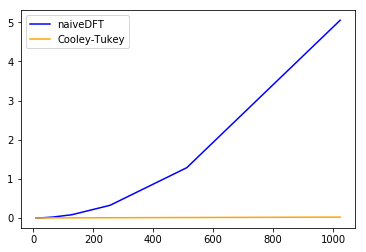

In [5]:
%matplotlib inline
from timeit import timeit

x = [8, 32, 64, 128, 256, 512, 1024]

setup = """
from __main__ import {}
import numpy as np
n = np.ones({})
N = len(n)
assert N == 0 or np.log2(N) % 1 == 0
"""
times = lambda name, x : [timeit("{}(n)".format(name), setup=setup.format(name, n), number=1) 
                          for n in x]

ex1_times = times(naiveDFT.__name__, x)
ex2_times = times(FFT.__name__, x)

plt.plot(x, ex1_times, color='blue', label='naiveDFT') 
plt.plot(x, ex2_times, color='orange', label='Cooley-Tukey')
plt.legend()

## Exercise 4 (application)

In this exercise, you will implement your very own efficient image compression method based on the DFT from scratch.

The 2-dimensional DFT of an $N_1\times N_2$ matrix $X=(X_{n_1,n_2})$ is an $N_1\times N_2$ matrix $Y=(Y_{k_1,k_2})$ satisfying

$$Y_{k_1,k_2}=\sum_{n_1=0}^{N_1-1}\sum_{n_2=0}^{N_2-1}e^{-2\pi i\left(\frac{k_1n_1}{N_1}+\frac{k_2n_2}{N_2}\right)}X_{n_1,n_2}$$

for every $k_1=0,1,\dots,N_1-1$ and $k_2=0,1,\dots,N_2-1$. Similarly to the 1-dimensional case, we may also write $Y=\mathcal{F}(X)$.

-  ## Exercise 4.1
    The 2-dimensional DFT $\mathcal{F}(X)$ can be easily computed using only the 1-dimensional DFT via the so-called row-column algorithm, which we describe below. For a matrix $M$, let $M_{i,\cdot}$ denote the $i$-th row of $M$, and let $M_{\cdot, j}$ denote the $j$-th column of $M$.
    
    - On input an $N_1\times N_2$ matrix $X$, compute $\mathcal{F}(X_{i,\cdot})$ for $i=0,1,\dots,N_1-1$. Let $Z$ be the $N_1\times N_2$ matrix such that $Z_{i,\cdot}=\mathcal{F}(X_{i,\cdot})$.
    
    - For each $j=0,1,\dots,N_2-1$, compute $\mathcal{F}(Z_{\cdot,j})$. Let $Y$ be the $N_1\times N_2$ matrix such that $Y_{\cdot,j}=\mathcal{F}(Z_{\cdot,j})$. Then, we have $Y=\mathcal{F}(X)$.
    
   Assuming $N_1$ and $N_2$ are powers of $2$, implement below the row-column algorithm for computing the 2-dimensional DFT of $X$ using the FFT algorithm from Exercise 2.

In [6]:
def FFT2(x):
    assert x.ndim == 2
    return np.apply_along_axis(FFT, 1, np.apply_along_axis(FFT, 0, x))

np.array_equal(FFT2(np.ones((8,8))), np.fft.fft2(np.ones((8,8))))

True

-  ## Exercise 4.2
    Recall from the Introduction that, in the 1-dimensional case with $\mathbf{x},\mathbf{y}\in\mathbb{C}^N$ and $\mathcal{F}(\mathbf{x})=\mathbf{y}$, we have
    
    $$x_k = \frac{\textrm{swap}\left(\mathcal{F}(\textrm{swap}(\mathbf{y}))_k\right)}{N}$$

    for $k=0,1,\dots,N-1$, where $\textrm{swap}(a+bi)=b+ai$.
    
    Combining this observation with the row-column algorithm described in Exercise 4.1, implement an algorithm that recovers $X\in\mathbb{C}^{N_1\times N_2}$ from $Y=\mathcal{F}(X)$ in time $O(N_1N_2\log(N_1N_2))$ whenever $N_1$ and $N_2$ are powers of $2$. Argue why the runtime of your algorithm is as required.

In [7]:
def swap(z):
    return complex(z.imag, z.real)
    
def invFFT1(y):
    assert y.ndim == 2
    a, b = y.shape
    assert np.log2(a) % 1 == 0 and np.log2(b) % 1 == 0
    
    swap_matrix = lambda m : np.vectorize(swap)(m) / a
    
    return swap_matrix(FFT2(swap_matrix(y)))

## Runtime of ```invFFT1```

<center>**```swap``` $=\mathcal{O}(c)$**</center> 

**```swap```** (lines 1-2) is applied each index in the matrix (**y**) of size $N_1\times N_2$ by the function **```swap_matrix```** (line 9): 
<br><br>

<center>**```swap_matrix```** $=\mathcal{O}(N_1N_2)\mathcal{O}(c)=\mathcal{O}(cN_1N_2)=\mathcal{O}(N_1N_2)$</center>

From this we see that the size of the matrix is not changing after the application of **```swap_matrix```**, we can say that the matrix size is poly-bounded under the function **```swap_matrix```**. Hence, **```swap_matrix(y)```**$(\mathbf{y})\leq\mathcal{O}(N_1N_2)$ (**).


Given that **```FFT```** $=\mathcal{O}(NlogN)$, **```FFT2```** $=\mathcal{O}(N_1N_2log(N_1N_2))$. Hence given the bounding of **```swap_matrix(y)```** (\*\*):


**```swap_matrix(FFT2(swap_matrix(y)))```**
<br>
$$
\begin{align}
&= \mathcal{O}(N_1N_2log(N_1N_2)) + \mathcal{O}(N_1N_2) + \mathcal{O}(N_1N_2) \\
&= \mathcal{O}(N_1N_2log(N_1N_2)) + 2 \mathcal{O}(N_1N_2) \\
&= \mathcal{O}(N_1N_2log(N_1N_2))  &  \text{as } N_1, N_2\rightarrow\infty
\end{align}
$$

In [8]:
y = np.fft.fft2(np.ones((4,4)))
np.array_equal(np.fft.ifft2(y), invFFT1(y))

True

-  ## Exercise 4.3
    You are now all set to implement the DFT-based image compression method. This method receives as input a matrix $X$ (which encodes a grayscale image) and a threshold $t>0$, and works as follows:
    
    -  Compute $Y=\mathcal{F}(X)$ using the algorithm from Exercise 4.1.
    
    -  Compute $\tilde{Y}$ from $Y$ by setting $\tilde{Y}_{k_1,k_2}=0$ if $|Y_{k_1,k_2}|<t$, and $\tilde{Y}_{k_1,k_2}=Y_{k_1,k_2}$ otherwise. Here, $|z|=\sqrt{a^2+b^2}$ is the modulus of a complex number $z=a+bi$.
    
    - Invert $\tilde{Y}$ using the algorithm from Exercise 4.2 to obtain $\tilde{X}$, which encodes the compressed image.
    
   Implement this algorithm.

In [9]:
def compressFFT(x, t):
    compute_pixel = lambda z : 0 if (np.absolute(z) < t) else z
    compress_v_func = np.vectorize(compute_pixel, otypes=[np.complex_])
    return invFFT1(compress_v_func(FFT2(x)))

-  ## Exercise 4.4

    To conclude, you will compress the image below
    
    ![title](turing.png)
    
    Apply your DFT-based compression method to the image above. Experiment with different thresholds, and showcase some of your attempts! You will find some code below for converting a grayscale image into an array, and for converting the output of the compression algorithm into a grayscale image.

In [10]:
from PIL import Image

def compress_image(t):
    img = Image.open('./turing.png').convert('L')
    img_array = np.array(img)
    img_array_complex = img_array.astype(np.complex_)
    
    #compressed_img_array is the output of your compression algorithm
    compressed_img_array = compressFFT(img_array_complex, t)
    
    #discard the imaginary part and round the values in your array to the nearest integer
    compressed_img_array_int = compressed_img_array.astype(np.uint8)

    #convert the rounded array into a grayscale image
    compressed_img = Image.fromarray(compressed_img_array_int, 'L')
    
    #save the image
    compressed_img.save('./turing_compressed_{}.png'.format(t))

In [12]:
from IPython.display import HTML, display

images_comparison = """
<table>
    <tr><th><center>Uncompressed</center></th><th><center>Compressed, t={}</center></th></tr>
    <tr><td><img src='turing.png'></td><td><img src='turing_compressed_{}.png'></td></tr>
</table>
"""
html = ""

ts = [10, 100, 1000, 10000]

for t in ts:
    compress_image(t)
    html += images_comparison.format(t, t)
    
display(HTML(html))

/Users/rajatrasal/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: ComplexWarning: Casting complex values to real discards the imaginary part


Uncompressed,"Compressed, t=10"
,
Uncompressed,"Compressed, t=100"
,
Uncompressed,"Compressed, t=1000"
,
Uncompressed,"Compressed, t=10000"
,


In [13]:
%%bash
echo '   File size comparison\n'
echo '   Size(B) | Filename'
echo '   --------|-----------'
ls -l| grep turing | awk '{printf("%10s | %8s \n", $5, $9)}'

   File size comparison\n
   Size(B) | Filename
   --------|-----------
    122485 | turing.png 
    125708 | turing_compressed_10.png 
    125191 | turing_compressed_100.png 
    119928 | turing_compressed_1000.png 
     98147 | turing_compressed_10000.png 
